In [22]:
include("../../src/Main.jl")
include("Geometry.jl")
using FerriteGmsh
using TimerOutputs

save_vtu = false
vtu_path = "results/"
geo_path = "geo/"

"geo/"

In [23]:
# Parameters
f_list = 10 .^ range(log10(1e3), log10(1e6), 20)
d = 0.32e-3
λ = 0.7168

ω_list = 2π * f_list
T = Complex{Float64}

ComplexF64 (alias for Complex{Float64})

In [24]:
# Generate mesh
A_cond = π / 4 * d^2
GenerateGeometryHex(d, λ, "geo_litz_hex"; path=geo_path)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 10%] Meshing curve 2 (Circle)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 20%] Meshing curve 5 (Line)
Info    : [ 30%] Meshing curve 6 (Line)
Info    : [ 30%] Meshing curve 7 (Line)
Info    : [ 40%] Meshing curve 8 (Line)
Info    : [ 40%] Meshing curve 9 (Circle)
Info    : [ 50%] Meshing curve 10 (Circle)
Info    : [ 50%] Meshing curve 11 (Circle)
Info    : [ 60%] Meshing curve 12 (Circle)
Info    : [ 60%] Meshing curve 13 (Circle)
Info    : [ 60%] Meshing curve 14 (Circle)
Info    : [ 70%] Meshing curve 15 (Circle)
Info    : [ 70%] Meshing curve 16 (Circle)
Info    : [ 80%] Meshing curve 17 (Circle)
Info    : [ 80%] Meshing curve 18 (Circle)
Info    : [ 90%] Meshing curve 19 (Circle)
Info    : [ 90%] Meshing curve 20 (Circle)
Info    : [100%] Meshing curve 21 (Circle)
Info    : [100%] Meshing curve 22 (Circle)
Info    : Done meshing 1D (Wall 0.00313401s, CPU 0s

In [25]:
# Simulation settings
materials = Dict(
    "Conductors" => Dict(
        "σ" => 59.6e6
    )
)

# Boundary conditions
## Simulation 1: Background flux density Bx = 1 T
boundaries_1 = Dict(
    "Domain" => BoundaryFlux((1, 0))
)

## Simulation 2: Background flux density By = 1 T
boundaries_2 = Dict(
    "Domain" => BoundaryFlux((0, 1))
)

## Simulation 3: No external field
boundaries_3 = Dict(
    "Domain" => BoundaryInfty(T)
)

Dict{String, BoundaryA{ComplexF64}} with 1 entry:
  "Domain" => BoundaryA{ComplexF64}(0.0+0.0im)

In [26]:
# Load the mesh using FerriteGmsh
grid = saved_file_to_grid(geo_path * "geo_litz_hex.msh")
preprocess_grid(grid);

Info    : Reading 'geo/geo_litz_hex.msh'...
Info    : 61 entities
Info    : 4312 nodes
Info    : 8622 elements
Info    : Done reading 'geo/geo_litz_hex.msh'


┌ Warning: no entities added to the set with name: cells_quad
└ @ Ferrite C:\Users\gijlag\.julia\packages\Ferrite\l74Rh\src\Grid\utils.jl:4


In [27]:
# Temporary storage for results
ν = zeros(T, (size(ω_list, 1), 2));
σ = zeros(T, size(ω_list));

In [28]:
# Loop through the frequencies
for (i, ω) ∈ enumerate(ω_list)
    println("Run $i of $(size(ω_list, 1)): f = $(f_list[i]) Hz")

    problem_1 = Problem2D{T}(symmetry=Planar2D(1), time=TimeHarmonic(ω), fe_order=2, qr_order=4, materials=materials, sources=Dict(), boundaries=boundaries_1)
    problem_2 = Problem2D{T}(symmetry=Planar2D(1), time=TimeHarmonic(ω), fe_order=2, qr_order=4, materials=materials, sources=Dict(), boundaries=boundaries_2)
    problem_3 = Problem2D{T}(symmetry=Planar2D(1), time=TimeHarmonic(ω), fe_order=2, qr_order=4, materials=materials, sources=Dict(), boundaries=boundaries_3)

    # Initialize FE problems and boundary constraints
    cv, dh = init_problem(problem_1, grid)
    ch1 = init_constraints(dh, problem_1)
    ch2 = init_constraints(dh, problem_2)
    ch3 = init_constraints(dh, problem_3)

    cellparams = init_params(dh, problem_1)

    # Circuit coupling 
    ## Simulations #1 and #2: no net current in the conductors
    cch1 = CircuitHandler(dh, T)
    add_current_coupling!(cch1, "Conductor1", 0, A_cond, 1)
    add_current_coupling!(cch1, "Conductor2", 0, A_cond, 1)
    add_current_coupling!(cch1, "Conductor3", 0, A_cond, 1)
    add_current_coupling!(cch1, "Conductor4", 0, A_cond, 1)
    add_current_coupling!(cch1, "Conductor5", 0, A_cond, 1)
    add_current_coupling!(cch1, "Conductor6", 0, A_cond, 1)
    add_current_coupling!(cch1, "Conductor7", 0, A_cond, 1)

    ## Simulations #3: 1A in each conductor
    cch3 = CircuitHandler(dh, T)
    add_current_coupling!(cch3, "Conductor1", 1, A_cond, 1)
    add_current_coupling!(cch3, "Conductor2", 1, A_cond, 1)
    add_current_coupling!(cch3, "Conductor3", 1, A_cond, 1)
    add_current_coupling!(cch3, "Conductor4", 1, A_cond, 1)
    add_current_coupling!(cch3, "Conductor5", 1, A_cond, 1)
    add_current_coupling!(cch3, "Conductor6", 1, A_cond, 1)
    add_current_coupling!(cch3, "Conductor7", 1, A_cond, 1)

    # Allocate matrices for each of the simulations
    K1 = allocate(dh, cch1, problem_1)
    K2 = allocate(dh, cch1, problem_2)
    K3 = allocate(dh, cch3, problem_3)

    K1, f1 = assemble_global(K1, dh, cv, problem_1, cellparams)
    K2, f2 = assemble_global(K2, dh, cv, problem_2, cellparams)
    K3, f3 = assemble_global(K3, dh, cv, problem_3, cellparams)

    # Apply the boundary constraints
    apply_circuit_couplings!(problem_1, problem_1.time, cellparams, K1, f1, cv, dh, cch1)
    apply_circuit_couplings!(problem_2, problem_2.time, cellparams, K2, f2, cv, dh, cch1)
    apply_circuit_couplings!(problem_3, problem_3.time, cellparams, K3, f3, cv, dh, cch3)

    apply!(K1, f1, ch1)
    apply!(K2, f2, ch2)
    apply!(K3, f3, ch3)

    # Solve the linear systems
    u1 = K1 \ f1
    u2 = K2 \ f2
    u3 = K3 \ f3

    # Post-processing
    ## Flux density
    B1 = ComputeFluxDensity(dh, cv, u1, problem_1, cellparams)
    B2 = ComputeFluxDensity(dh, cv, u2, problem_2, cellparams)
    B3 = ComputeFluxDensity(dh, cv, u3, problem_3, cellparams)

    ## Current density
    J1 = ComputeCurrentDensity(dh, cv, cch1, u1, problem_1, cellparams)
    J2 = ComputeCurrentDensity(dh, cv, cch1, u2, problem_2, cellparams)
    J3 = ComputeCurrentDensity(dh, cv, cch3, u3, problem_3, cellparams)

    ## Loss density
    S1 = ComputeLossDensity(dh, cv, J1, B1, problem_1, cellparams)
    S2 = ComputeLossDensity(dh, cv, J2, B2, problem_2, cellparams)
    S3 = ComputeLossDensity(dh, cv, J3, B3, problem_3, cellparams)

    ## Homogenization parameters
    #   Sim #1 (Bx = 1T) -> νxx
    #   Sim #2 (By = 1T) -> νyy
    #   Sim #3 (Iz = 1A) -> σzz
    #  The other outputs do not have any physical meaning
    (νxx, _, _) = ComputeHomogenization(dh, cv, "Cell0", J1, B1, S1, problem_1)
    (_, νyy, _) = ComputeHomogenization(dh, cv, "Cell0", J2, B2, S2, problem_2)
    (_, _, σzz) = ComputeHomogenization(dh, cv, "Cell0", J3, B3, S3, problem_3)

    ## Store the homogenization parameters
    ν[i, 1] = νxx
    ν[i, 2] = νyy
    σ[i] = σzz

    ## Save the FE results (current densities) if desired.
    if (save_vtu)
        VTKGridFile(vtu_path * "litz_hex_$i", dh; write_discontinuous=true) do vtk
            write_postprocessed(vtk, dh, cch1, u1, problem_1, cellparams, :B_norm, "B1_norm")
            write_postprocessed(vtk, dh, cch1, u2, problem_2, cellparams, :B_norm, "B2_norm")
            write_postprocessed(vtk, dh, cch3, u3, problem_3, cellparams, :B_norm, "B3_norm")
            write_postprocessed(vtk, dh, cch1, u1, problem_1, cellparams, :J_norm, "J1_norm")
            write_postprocessed(vtk, dh, cch1, u2, problem_2, cellparams, :J_norm, "J2_norm")
            write_postprocessed(vtk, dh, cch3, u3, problem_3, cellparams, :J_norm, "J3_norm")
        end
    end
end

Run 1 of 20: f = 1000.0 Hz
Run 2 of 20: f = 1438.449888287663 Hz
Run 3 of 20: f = 2069.13808111479 Hz
Run 4 of 20: f = 2976.351441631319 Hz
Run 5 of 20: f = 4281.332398719395 Hz
Run 6 of 20: f = 6158.48211066026 Hz
Run 7 of 20: f = 8858.667904100823 Hz
Run 8 of 20: f = 12742.749857031347 Hz
Run 9 of 20: f = 18329.807108324374 Hz
Run 10 of 20: f = 26366.50898730361 Hz
Run 11 of 20: f = 37926.90190732246 Hz
Run 12 of 20: f = 54555.947811685146 Hz
Run 13 of 20: f = 78475.99703514607 Hz
Run 14 of 20: f = 112883.78916846884 Hz
Run 15 of 20: f = 162377.67391887208 Hz
Run 16 of 20: f = 233572.14690901214 Hz
Run 17 of 20: f = 335981.8286283781 Hz
Run 18 of 20: f = 483293.0238571752 Hz
Run 19 of 20: f = 695192.7961775606 Hz
Run 20 of 20: f = 1.0e6 Hz


In [29]:
using CairoMakie

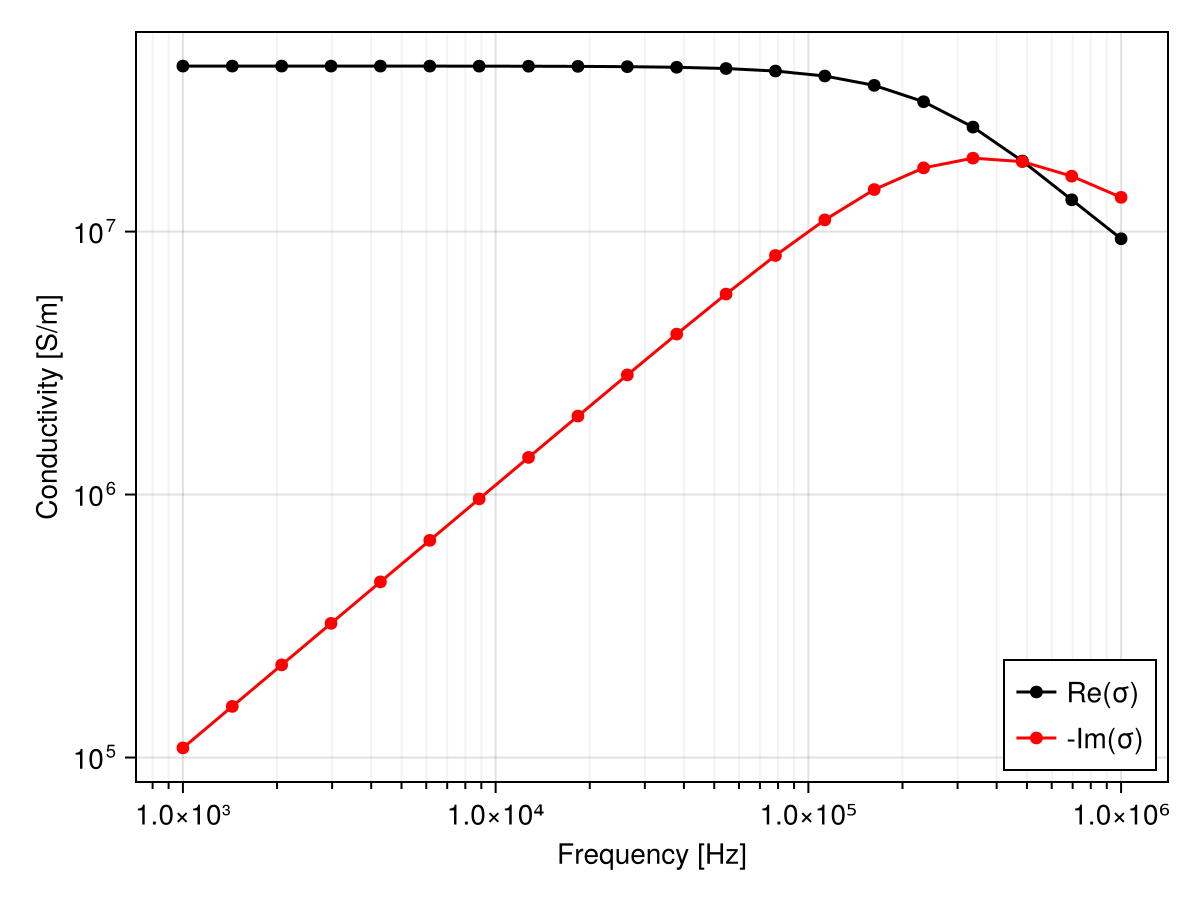

CairoMakie.Screen{IMAGE}


In [30]:
fig = Figure()
ax = Axis(fig[1, 1],
    xlabel="Frequency [Hz]", ylabel="Conductivity [S/m]",
    xticks=[1e3, 10e3, 100e3, 1e6, 1e7],
    xminorticksvisible=true, xminorgridvisible=true, xminorticks=IntervalsBetween(9),
    xscale=log10, yscale=log10
)

scatterlines!(ax, f_list, real.(σ), color=:black, label="Re(σ)")
scatterlines!(ax, f_list, -imag.(σ), color=:red, label="-Im(σ)")
axislegend(position=:rb)

display(fig)

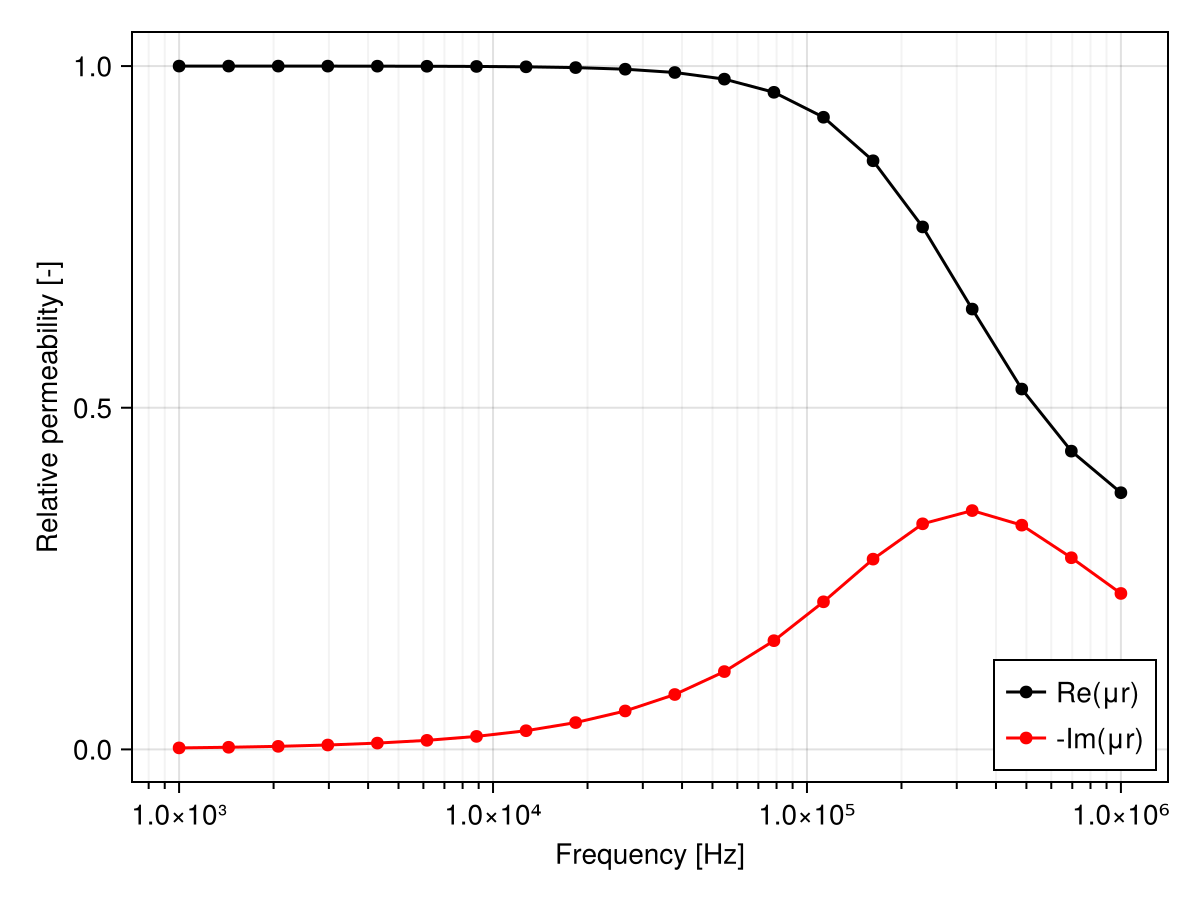

CairoMakie.Screen{IMAGE}


In [ ]:
fig = Figure()
ax = Axis(fig[1, 1],
    xlabel="Frequency [Hz]", ylabel="Relative permeability [-]",
    xticks=[1e3, 10e3, 100e3, 1e6, 1e7],
    xminorticksvisible=true, xminorgridvisible=true, xminorticks=IntervalsBetween(9),
    xscale=log10
)

μ = 1 ./ ν[:, 1]
scatterlines!(ax, f_list, real.(μ / μ0), color=:black, label="Re(μr)")
scatterlines!(ax, f_list, -imag.(μ / μ0), color=:red, label="-Im(μr)")
axislegend(position=:rb)

display(fig)

In [32]:
μ0

1.2566370614359173e-6